#### Libraries

In [440]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.metrics import Precision, Recall

from sklearn.linear_model import LogisticRegression



### Creating functions

In [441]:
def categorize_icd9(code):
    """ Convert ICD-9 codes into broad disease categories """
    if pd.isna(code):
        return "Unknown"
    code = str(code)
    
    if code.startswith('V'):
        return "V-Code (Health Services)"
    if code.startswith('E'):
        return "E-Code (External Injury)"

    try:
        code = int(float(code))  # Convert numeric ICD-9 codes
        if 1 <= code <= 139:
            return "Infectious Disease"
        elif 140 <= code <= 239:
            return "Neoplasms"
        elif 240 <= code <= 279:
            return "Endocrine (e.g., Diabetes)"
        elif 280 <= code <= 289:
            return "Blood Diseases"
        elif 290 <= code <= 319:
            return "Mental Disorders"
        elif 320 <= code <= 389:
            return "Nervous System"
        elif 390 <= code <= 459:
            return "Circulatory System"
        elif 460 <= code <= 519:
            return "Respiratory System"
        elif 520 <= code <= 579:
            return "Digestive System"
        elif 580 <= code <= 629:
            return "Genitourinary System"
        elif 630 <= code <= 679:
            return "Pregnancy-related"
        elif 680 <= code <= 709:
            return "Skin Diseases"
        elif 710 <= code <= 739:
            return "Musculoskeletal"
        elif 740 <= code <= 759:
            return "Congenital Disorders"
        elif 760 <= code <= 779:
            return "Perinatal Conditions"
        elif 780 <= code <= 799:
            return "Symptoms & Ill-defined"
        elif 800 <= code <= 999:
            return "Injury & Poisoning"
    except ValueError:
        return "Unknown"
    
    return "Other"


### Importing data

In [442]:
data= pd.read_csv('diabetic_data.csv')
#missing values in dataset are represented by '?' so we replace them with NaN
data.replace('?', np.nan, inplace=True)

In [443]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [444]:
# Cheking if rows need encoding

numerical_columns = list(data.select_dtypes(include=['number']).columns)
categorical_columns = data.select_dtypes(include='object').columns

print("Numerical Columns:")
print("\n".join(f"- {col}" for col in numerical_columns))
print("\nCategorical Columns:")
print("\n".join(f"- {col}" for col in categorical_columns))

Numerical Columns:
- encounter_id
- patient_nbr
- admission_type_id
- discharge_disposition_id
- admission_source_id
- time_in_hospital
- num_lab_procedures
- num_procedures
- num_medications
- number_outpatient
- number_emergency
- number_inpatient
- number_diagnoses

Categorical Columns:
- race
- gender
- age
- weight
- payer_code
- medical_specialty
- diag_1
- diag_2
- diag_3
- max_glu_serum
- A1Cresult
- metformin
- repaglinide
- nateglinide
- chlorpropamide
- glimepiride
- acetohexamide
- glipizide
- glyburide
- tolbutamide
- pioglitazone
- rosiglitazone
- acarbose
- miglitol
- troglitazone
- tolazamide
- examide
- citoglipton
- insulin
- glyburide-metformin
- glipizide-metformin
- glimepiride-pioglitazone
- metformin-rosiglitazone
- metformin-pioglitazone
- change
- diabetesMed
- readmitted


In [445]:
data.sample(5).T

,13690,48817,44832,61611,43284
encounter_id,54101196,148501572,138396858,171950640,133617558
patient_nbr,1363635,110526336,47461050,101783772,51883236
race,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Male,Female,Male,Female,Female
age,[60-70),[70-80),[60-70),[80-90),[70-80)
weight,NaN,NaN,NaN,NaN,NaN
admission_type_id,3,1,1,2,2
discharge_disposition_id,1,6,1,3,1
admission_source_id,1,7,1,7,7
time_in_hospital,1,6,1,6,6


### Cheching missing values

In [446]:
print('gender', data['gender'][data['gender'] == 'Unknown/Invalid'].count())            

gender 3


In [447]:
data = data[data['gender'] != 'Unknown/Invalid']

In [448]:
#checking missing values

missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending= False).round(3)

missing_data = pd.DataFrame({
    'Count': missing_values,
    'Percent': missing_percent*100
})

missing_data = missing_data[missing_data['Count'] > 0].sort_values(by='Count', ascending=False)

print("Missing Values in Specified Columns:")
print(missing_data)

Missing Values in Specified Columns:
                   Count  Percent
weight             98566     96.9
max_glu_serum      96417     94.7
A1Cresult          84745     83.3
medical_specialty  49947     49.1
payer_code         40255     39.6
race                2271      2.2
diag_3              1423      1.4
diag_2               358      0.4
diag_1                21      0.0


In [449]:
# drop columns with more than 30% missing values
data= data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

# drop rows with missing values
data= data.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'])

# Fill NaN values with 0 using explicit assignment to avoid FutureWarning
data = data.copy()  # Ensure we're modifying the original DataFrame
data['max_glu_serum'] = data['max_glu_serum'].fillna(0)
data['A1Cresult'] = data['A1Cresult'].fillna(0)

# Verify the changes
print(data['max_glu_serum'].value_counts(dropna=False))
print(data['A1Cresult'].value_counts(dropna=False))




max_glu_serum
0       92844
Norm     2532
>200     1449
>300     1227
Name: count, dtype: int64
A1Cresult
0       81859
>8       7631
Norm     4854
>7       3708
Name: count, dtype: int64


In [450]:
missing_values = data.isnull().sum()

if missing_values.any():
        print(missing_values[missing_values>0])
else:
    print('No missing values')

No missing values


## Analise data

In [451]:
# Convert the target variable to binary
data['readmitted_binary'] = data['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})

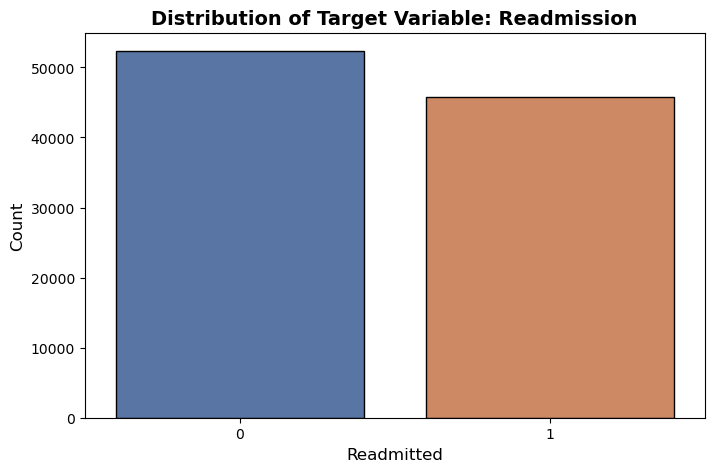

In [452]:
#analizing the target variable

plt.figure(figsize=(8, 5))

sns.countplot(x='readmitted_binary', data=data, hue='readmitted_binary', palette='deep', edgecolor='black', legend=False)

plt.title('Distribution of Target Variable: Readmission', fontsize=14, fontweight='bold')
plt.xlabel('Readmitted', fontsize=12)
plt.ylabel('Count', fontsize=12)


plt.show()

<Axes: ylabel='proportion'>

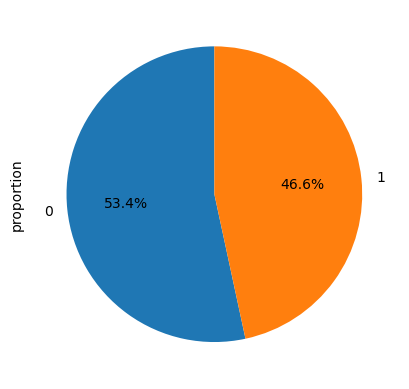

In [453]:
# show target variable distribution in percentage

readmitted_percent = data['readmitted_binary'].value_counts(normalize=True) * 100

readmitted_percent.plot(kind='pie', autopct='%1.1f%%', startangle=90)

Text(0.5, 1.0, 'Gender Distribution')

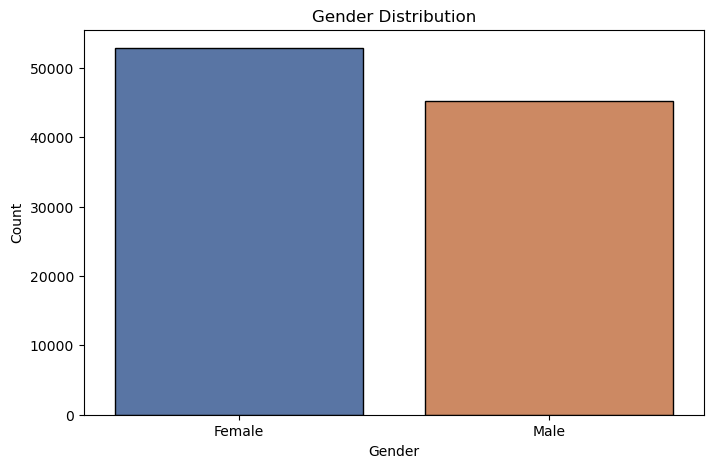

In [454]:
# Display age group distribution
plt.figure(figsize=(8, 5))

ax=sns.countplot(x='gender', data=data,hue= 'gender', palette='deep', edgecolor='black', legend=False)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')


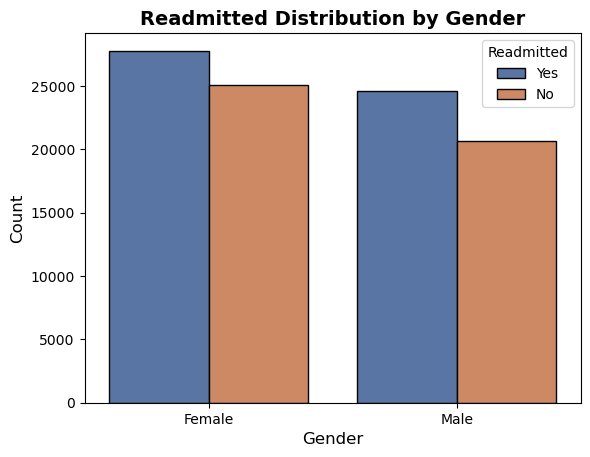

In [455]:
# Plot count of readmitted patients by gender
sns.countplot(x='gender', hue='readmitted_binary', data=data, palette='deep', edgecolor='black')

# Set tick positions and labels explicitly
ax.set_xticks([0, 1]) 
ax.set_xticklabels(['Male', 'Female']) 

# Labels and title
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.title('Readmitted Distribution by Gender', fontsize=14, fontweight='bold')
plt.legend(title="Readmitted", labels=["Yes", "No",])


plt.show()

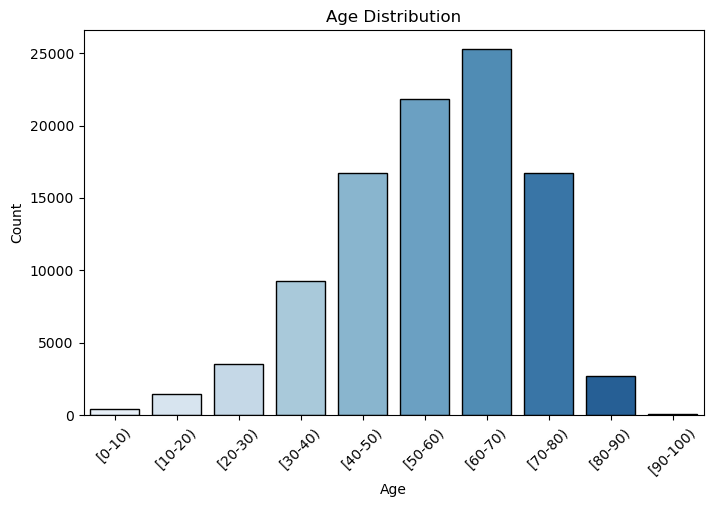

In [456]:
age_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
age_labels = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
              '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

plt.figure(figsize=(8, 5))

ax=sns.countplot(x="age", data = data, hue= 'age', palette='Blues', edgecolor='black', legend=False)

plt.xticks(ticks=age_order, labels=age_labels, rotation=45)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

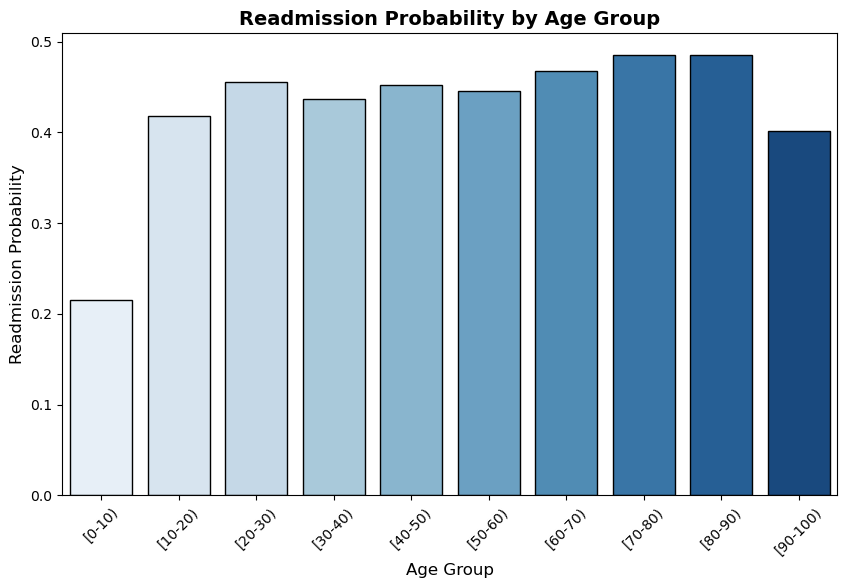

In [457]:
# Compute readmission probability per age group
data['readmitted_binary'] = data['readmitted_binary'].astype(int)
age_readmit_rates = data.groupby('age')['readmitted_binary'].mean().reset_index()

# Plot as a proper vertical bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="age", y="readmitted_binary",hue='age', data=age_readmit_rates, palette="Blues", edgecolor="black")

plt.xticks(ticks=age_order, labels=age_labels, rotation=45)

# Labels & Title
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Readmission Probability", fontsize=12)
plt.title("Readmission Probability by Age Group", fontsize=14, fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


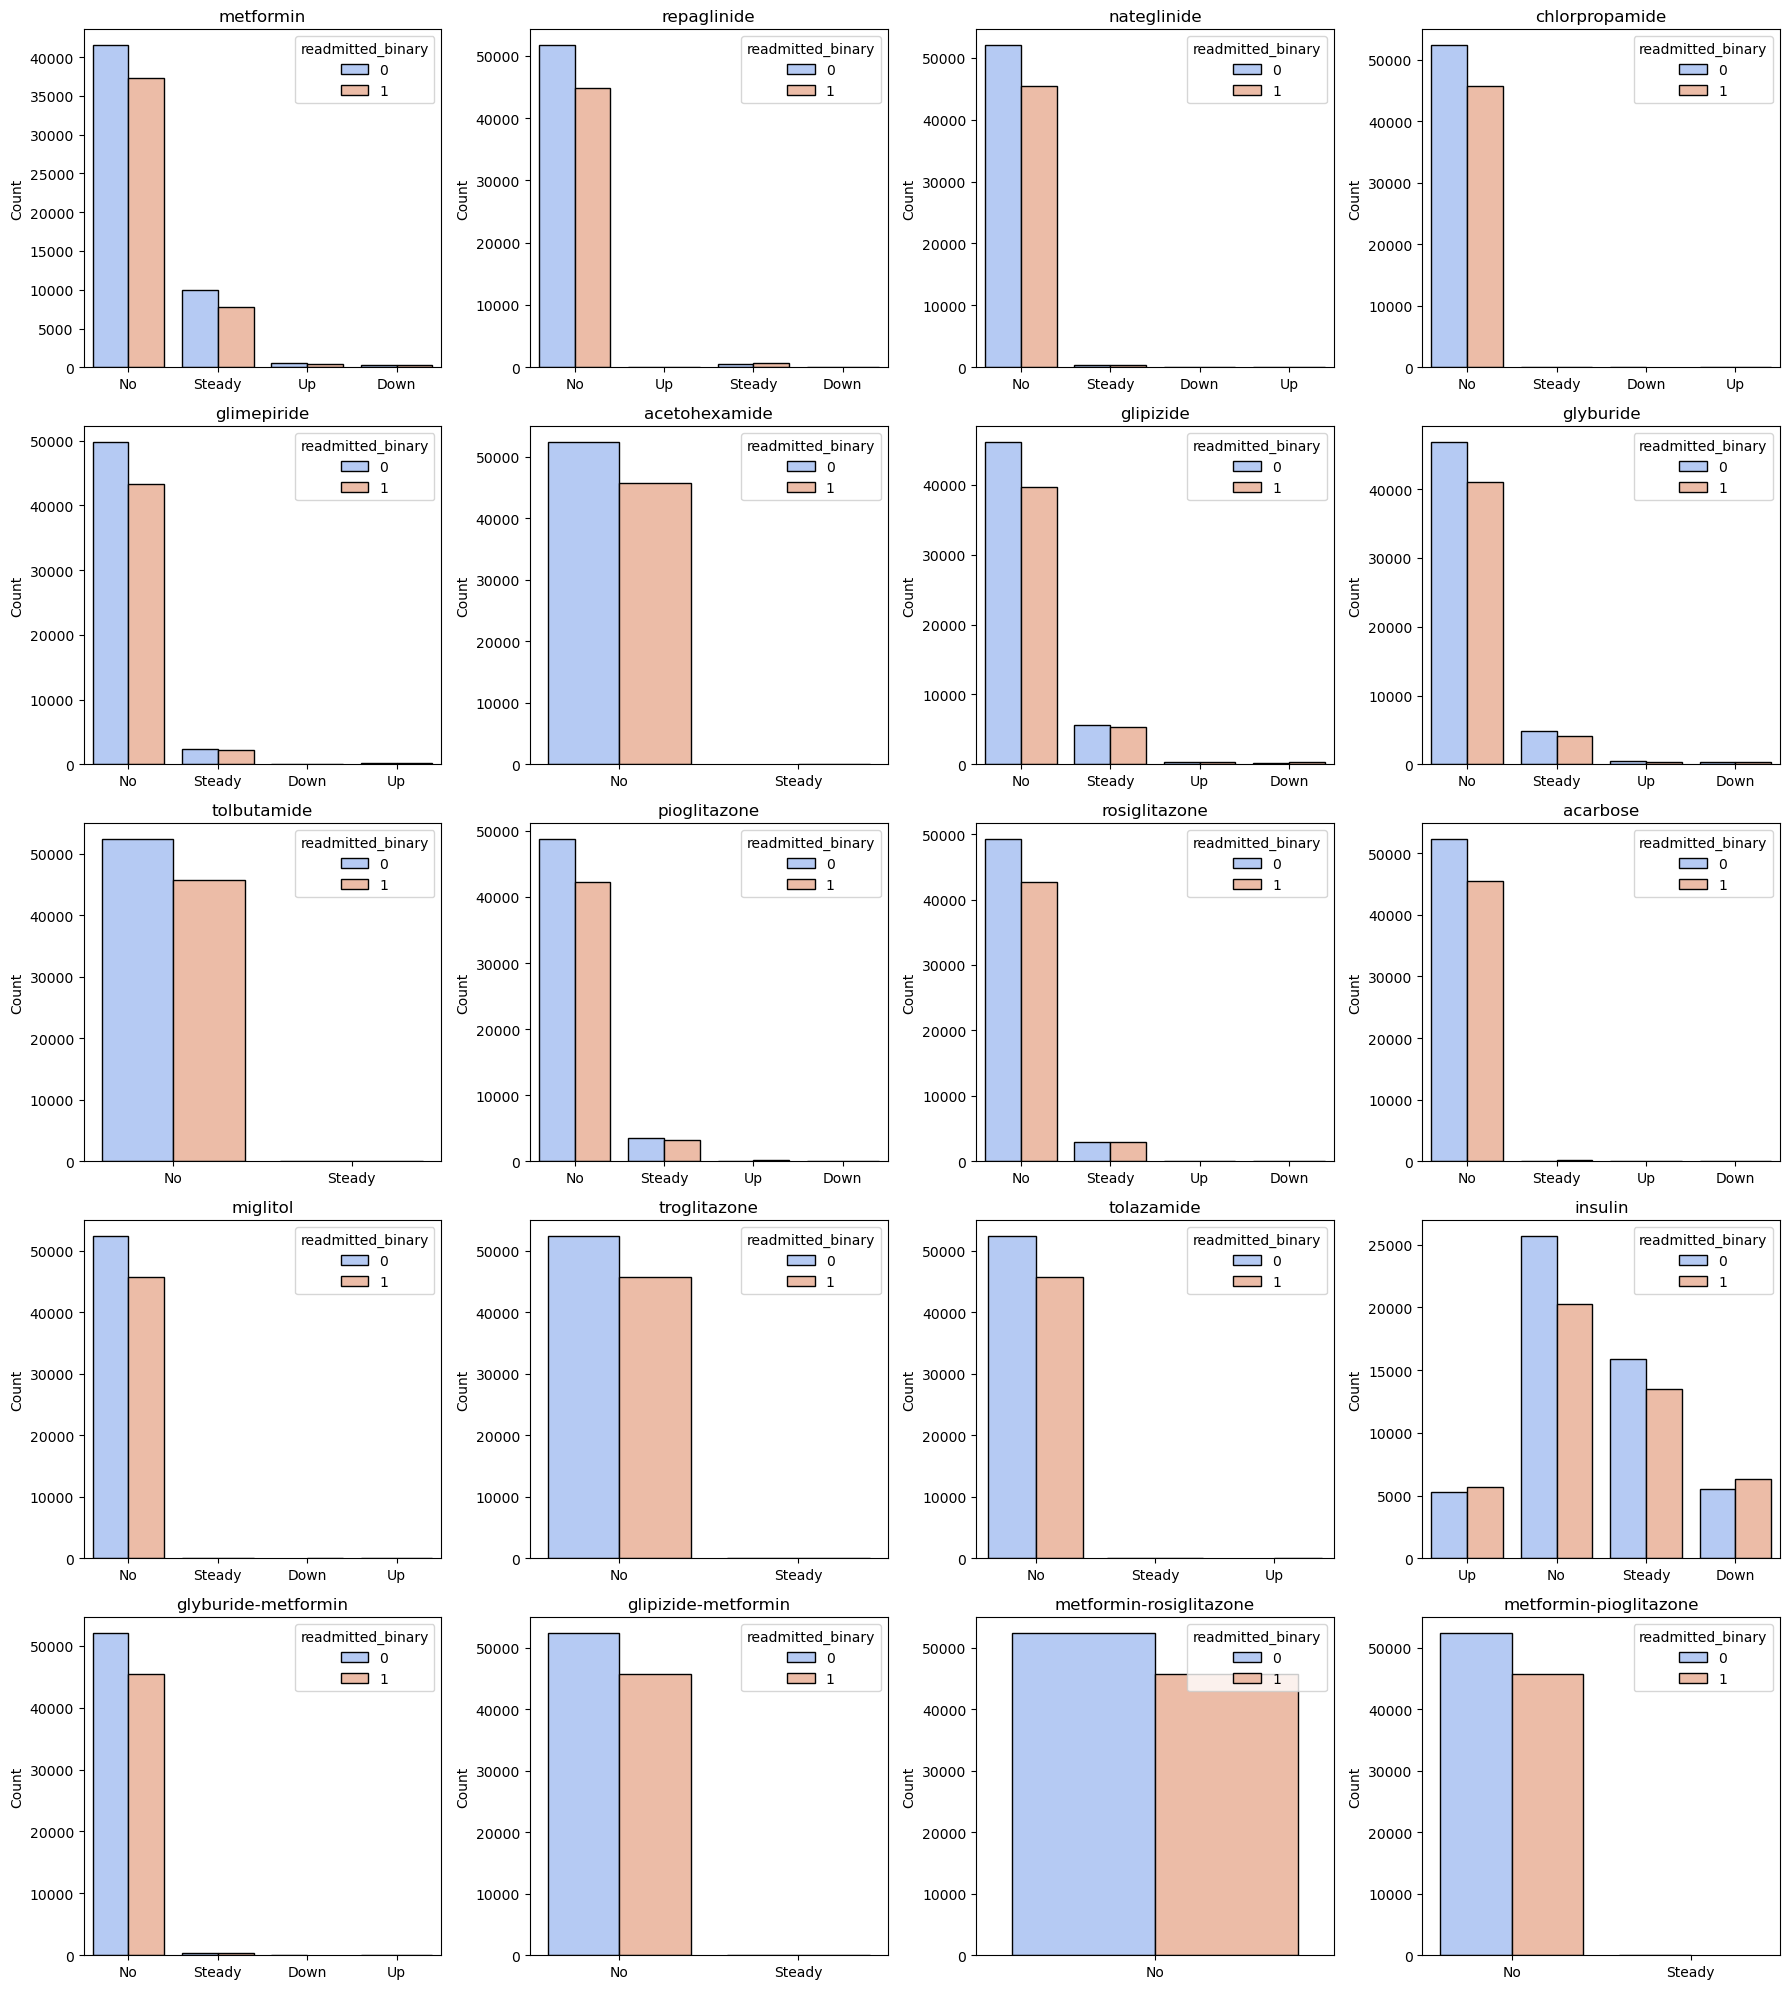

In [458]:
# List of drug columns
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']

# Create subplots with multiple drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))  # Adjust grid size dynamically
axes = axes.flatten()  # Flatten to loop over

# Loop through each drug and plot on its respective subplot
for idx, drug in enumerate(drug_cols):
    sns.countplot(x=drug, hue="readmitted_binary", data=data, palette="coolwarm", edgecolor="black", ax=axes[idx])
    axes[idx].set_title(drug, fontsize=12)
    axes[idx].set_xlabel("")  # Remove redundant x-labels
    axes[idx].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

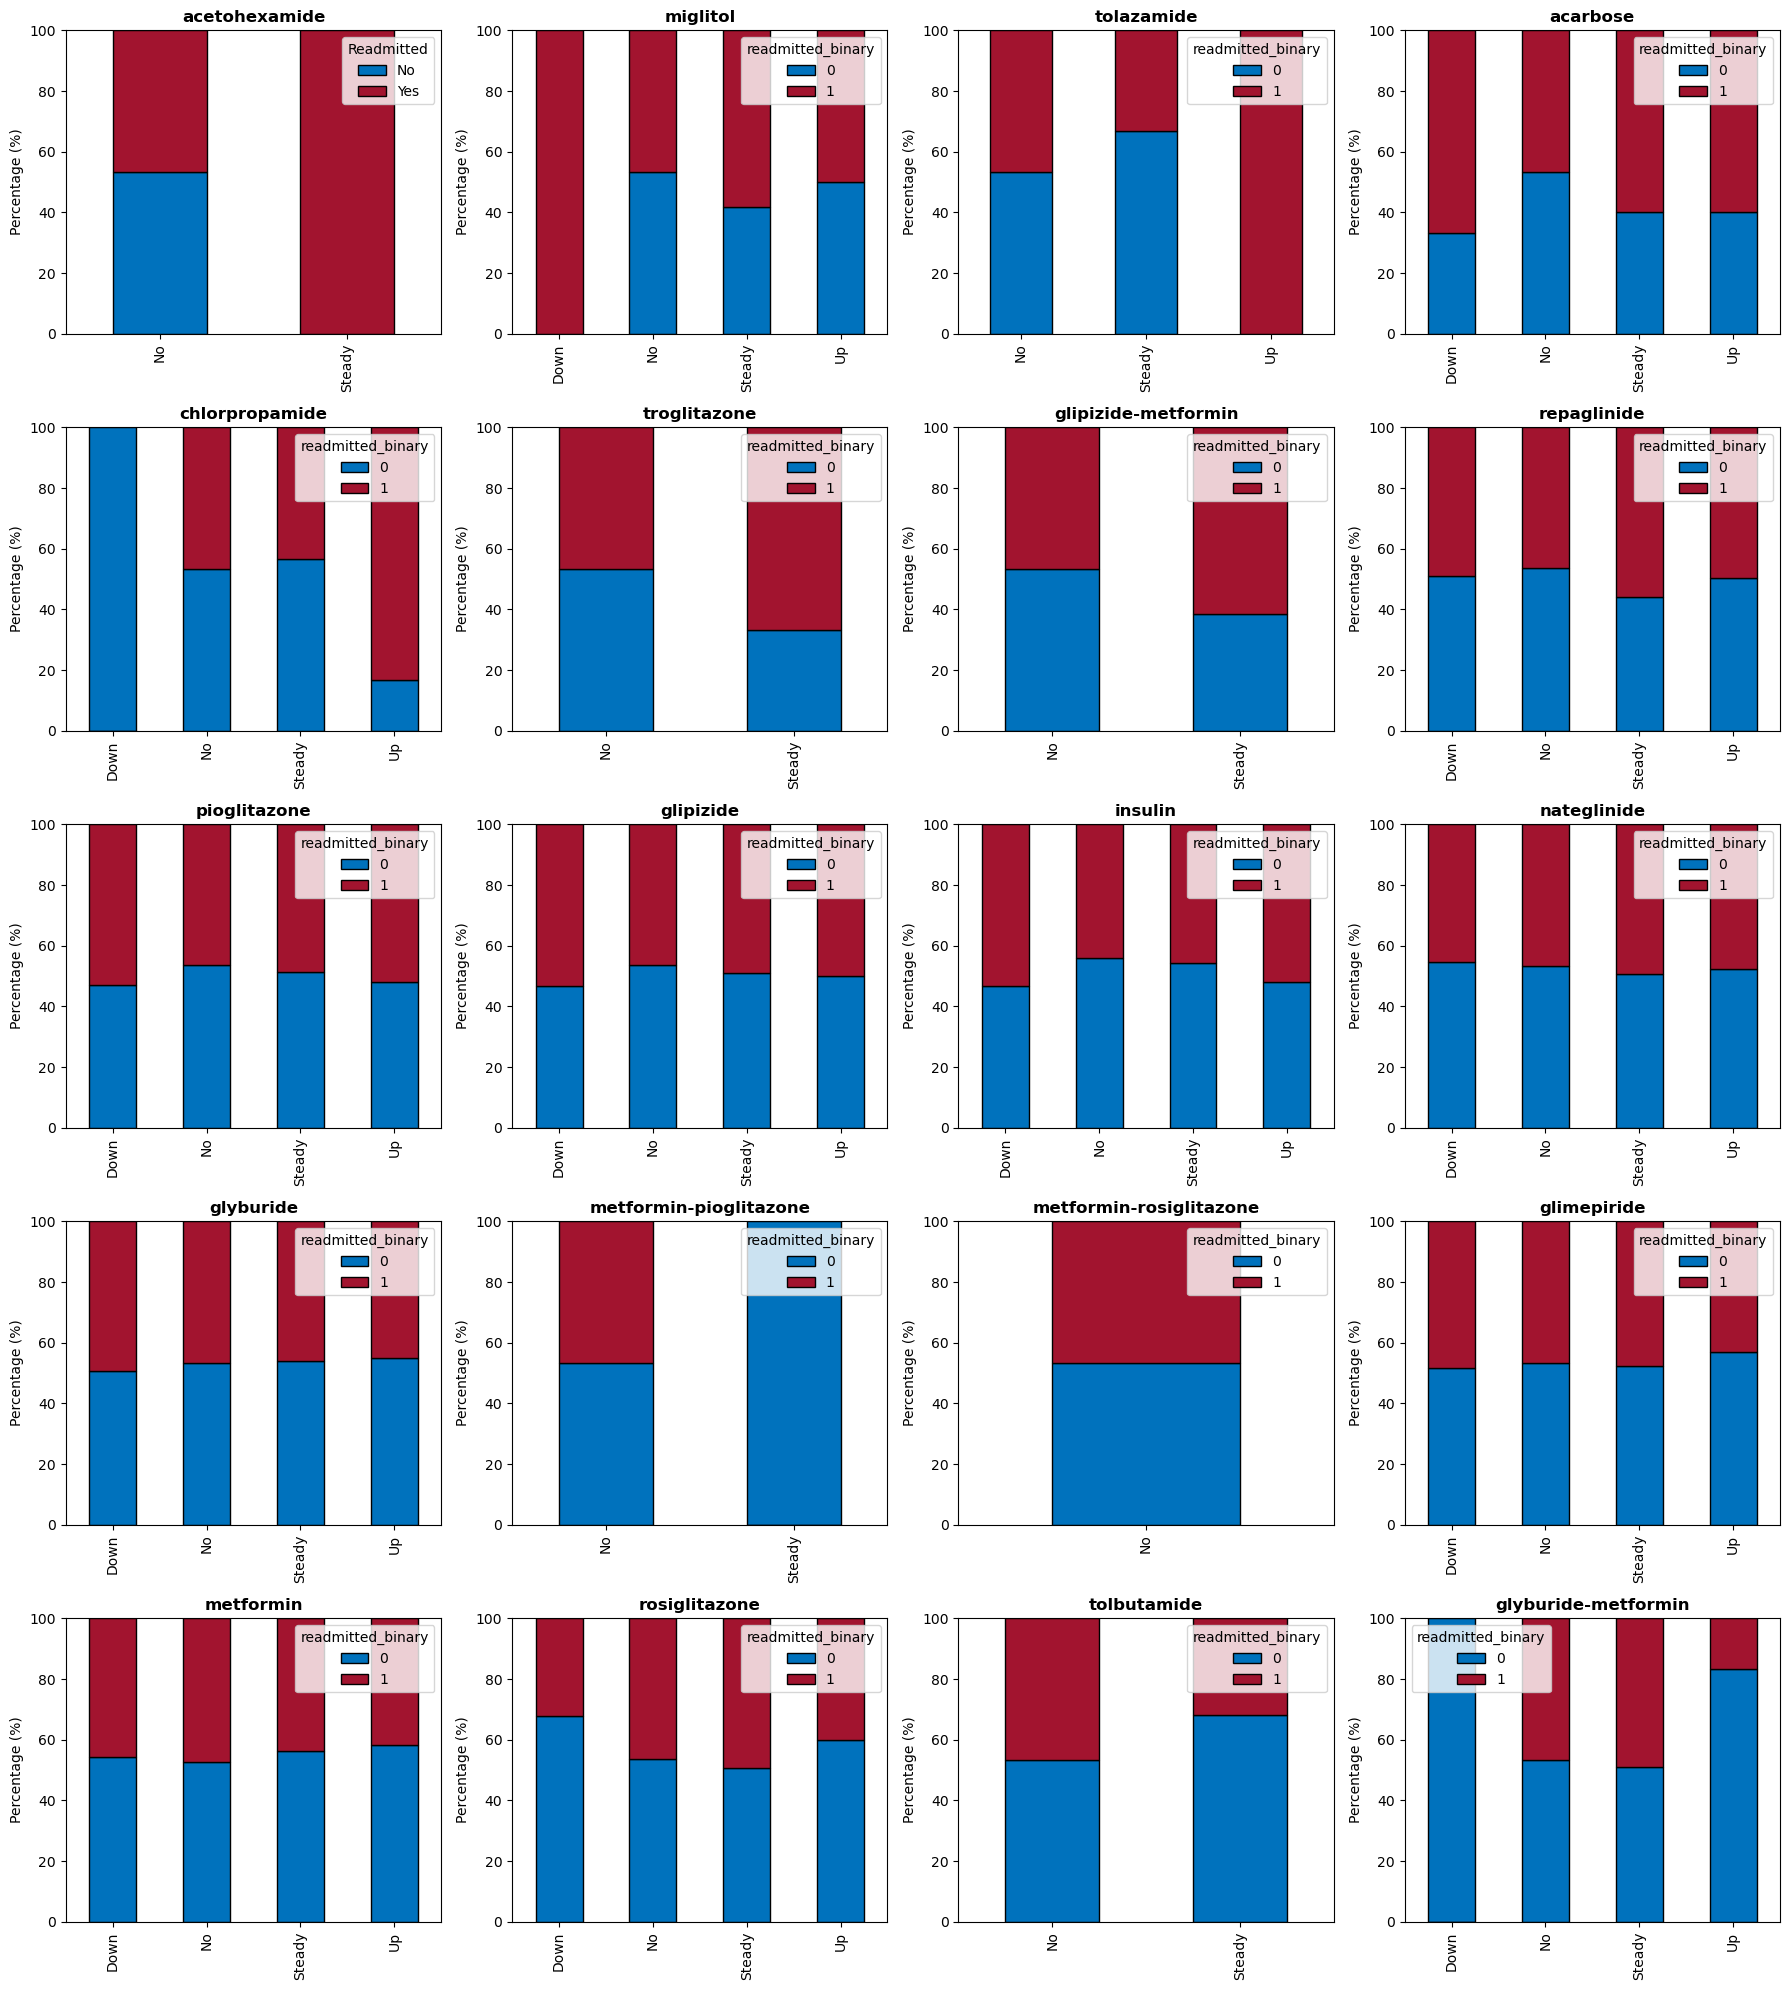

In [459]:
# Compute readmission percentage for each drug
drug_readmit_rates = {}
for drug in drug_cols:
    drug_counts = data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100
    avg_readmit_rate = drug_percent[1].mean()  # Avg. percentage of readmitted
    drug_readmit_rates[drug] = avg_readmit_rate

# Sort drugs by highest readmission percentage
sorted_drugs = sorted(drug_readmit_rates, key=drug_readmit_rates.get, reverse=True)

# Create subplots with sorted drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))  
axes = axes.flatten()  

# Loop through sorted drugs and plot on subplots
for idx, drug in enumerate(sorted_drugs):
    drug_counts = data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100  
    
    # Plot as stacked bar chart
    drug_percent.plot(kind='bar', stacked=True, ax=axes[idx], color=["#0072BD", "#A2142F"], edgecolor="black")

    # Formatting
    axes[idx].set_title(drug, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].set_ylim(0, 100)  # Ensure consistent scaling

    # Move legend outside to avoid overlap
    if idx == 0:
        axes[idx].legend(title="Readmitted", labels=["No", "Yes"], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

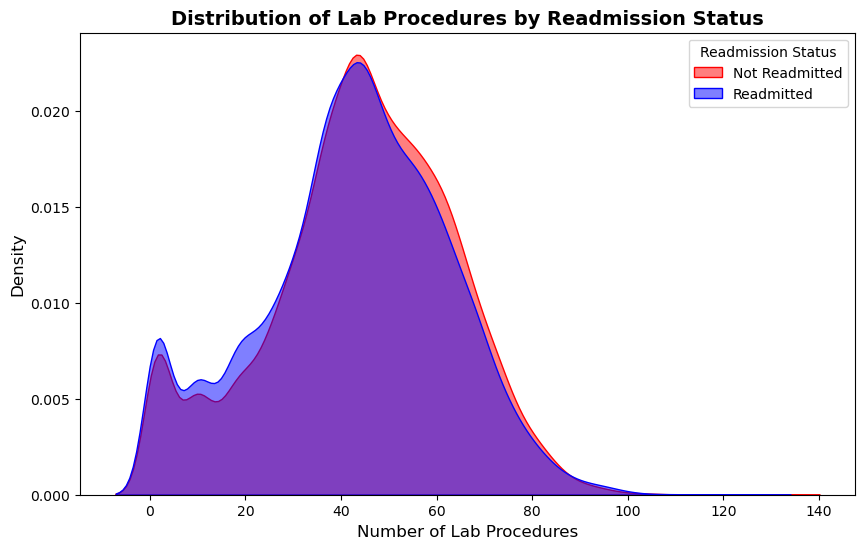

In [460]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=data, x="num_lab_procedures", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)  # Smooth bandwidth adjustment

# Labels & Title
plt.xlabel("Number of Lab Procedures", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Lab Procedures by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


In [461]:
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.72%
Maximum number of admissions for a given patient: 39


In [462]:
# Unique admissions & patients
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

# Count admissions per patient
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']

# Identify patients with multiple admissions
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

# Compute additional insights
multiple_admission_rate = multiple_admissions['patient_nbr'].nunique() / n_patients
max_admissions = multiple_admissions['count'].max()


# Display key statistics
print("="*50)
print(f"Total Admissions: {n_admissions:,}")
print(f"Total Unique Patients: {n_patients:,}")
print(f"Proportion of Patients with Multiple Admissions: {multiple_admission_rate:.2%}")
print(f"Maximum Number of Admissions for a Single Patient: {max_admissions}")
print("="*50)


Total Admissions: 98,052
Total Unique Patients: 68,629
Proportion of Patients with Multiple Admissions: 23.72%
Maximum Number of Admissions for a Single Patient: 39


## Feature Engeniering

### Clearing and Lablind data

In [463]:
numerical_columns = list(data.select_dtypes(include=['number']).columns)
categorical_columns =   data.select_dtypes(include='object').columns

### Remapping Categorical values

In [464]:
# labling variables

# Encoding gender column
gender_mapping = {'Male': 0, 'Female': 1}
data['gender'] = data['gender'].map(gender_mapping)

# Encoding race column
race_mapping = {'Caucasian': 0, 'AfricanAmerican': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4}
data['race']= data['race'].map(race_mapping)

# Encoding change column
change_mapping = {'No': 0, 'Ch': 1}
data['change'] = data['change'].map(change_mapping)

# Encoding diabetesMed column
diabetesMed_mapping = {'No': 0, 'Yes': 1}
data['diabetesMed'] = data['diabetesMed'].map(diabetesMed_mapping)


# Encoding age groups into lables for classification
age_mapping2 = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, 
    '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
}

# Apply mapping to replace categorical age groups with numerical values
data['age_lable'] = data['age'].map(age_mapping2)

# Convert to NumPy array for model input
age_input = np.array(data['age'])


# Define the mapping for max_glu_serum
max_glu_serum_map = {
    '0': 0,  # Test not taken
    'Norm': 1,
    '>200': 2,
    '>300': 3
}

# Define the mapping for A1Cresult
A1Cresult_map = {
    '0': 0,  # Test not taken
    'Norm': 1,
    '>7': 2,
    '>8': 3
}

# Apply the mapping
data['max_glu_serum'] = data['max_glu_serum'].astype(str).map(max_glu_serum_map)
data['A1Cresult'] = data['A1Cresult'].astype(str).map(A1Cresult_map)

print(data['max_glu_serum'].value_counts(dropna=False))
print(data['A1Cresult'].value_counts(dropna=False))


max_glu_serum
0    92844
1     2532
2     1449
3     1227
Name: count, dtype: int64
A1Cresult
0    81859
3     7631
1     4854
2     3708
Name: count, dtype: int64


In [465]:
# List of drug columns
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone','examide', 'citoglipton', 'glimepiride-pioglitazone']

# Dictionary to store label encoders for future decoding
drug_label_encoders = {}

# Convert categorical drug columns to numeric labels
for col in drug_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Apply encoding
    drug_label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Store mapping


### Creating new features

In [466]:
#categorize ICD-9 codes into disease categories
data['diag_1_category'] = data['diag_1'].apply(categorize_icd9)
data['diag_2_category'] = data['diag_2'].apply(categorize_icd9)
data['diag_3_category'] = data['diag_3'].apply(categorize_icd9)

In [467]:
# creating a number of visits column

data['num_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']

In [468]:
# labling categorized ICD-9 codes
# List of drug columns
diag_cols = ['diag_1_category', 'diag_2_category', 'diag_3_category']

# Dictionary to store label encoders for future decoding
diag_cols_encoders = {}

# Convert categorical drug columns to numeric labels
for col in diag_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Apply encoding
    diag_cols_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Store mapping

In [469]:
import pandas as pd

# Ensure required columns exist in DataFrame before proceeding
existing_columns = set(data.columns)

# Define interaction terms (Only keep valid ones)
datainteractionterms = [
    ('num_medications', 'time_in_hospital'),
    ('num_medications', 'num_procedures'),
    ('time_in_hospital', 'num_lab_procedures'),
    ('num_medications', 'num_lab_procedures'),
    ('num_medications', 'number_diagnoses'),
    ('change', 'num_medications'),
    ('number_diagnoses', 'time_in_hospital'),
    ('num_medications', 'num_visits')  
]

# Filter interaction terms to keep only existing columns
valid_interaction_terms = [(col1, col2) for col1, col2 in datainteractionterms if col1 in existing_columns and col2 in existing_columns]
# Ensure all relevant columns are numeric
for col1, col2 in valid_interaction_terms:
    data[col1] = pd.to_numeric(data[col1], errors='coerce')
    data[col2] = pd.to_numeric(data[col2], errors='coerce')

# Generate interaction terms
for col1, col2 in valid_interaction_terms:
    name = col1 + '|' + col2
    
    # Multiplication
    new_col_mult = name + '_mult'
    data[new_col_mult] = data[col1] * data[col2]
    numerical_columns.append(new_col_mult)

    # Addition
    new_col_sum = name + '_sum'
    data[new_col_sum] = data[col1] + data[col2]
    numerical_columns.append(new_col_sum)

    # Division (Avoiding division by zero)
    new_col_ratio = name + '_ratio'
    data[new_col_ratio] = data[col1] / (data[col2] + 1e-5)
    numerical_columns.append(new_col_ratio)

# Remove duplicate column names in numerical_columns
numerical_columns = list(set(numerical_columns))

# Generate Polynomial Features
data['num_medications_squared'] = data['num_medications'] ** 2
data['time_in_hospital_squared'] = data['time_in_hospital'] ** 2
data['number_diagnoses_squared'] = data['number_diagnoses'] ** 2

# Add polynomial features to numerical_columns
numerical_columns.extend(['num_medications_squared', 'time_in_hospital_squared', 'number_diagnoses_squared'])

# Generate Healthcare Utilization Ratios
data['num_medications_time_in_hospital_ratio'] = data['num_medications'] / (data['time_in_hospital'] + 1e-5)
data['num_medications_num_lab_procedures_ratio'] = data['num_medications'] / (data['num_lab_procedures'] + 1e-5)
data['number_diagnoses_time_in_hospital_ratio'] = data['number_diagnoses'] / (data['time_in_hospital'] + 1e-5)

# Add ratio features to numerical_columns
numerical_columns.extend(['num_medications_time_in_hospital_ratio', 'num_medications_num_lab_procedures_ratio', 'number_diagnoses_time_in_hospital_ratio'])

# Ensure numerical_columns does not have duplicates
numerical_columns = list(set(numerical_columns))

# Display object columns (if any exist)
object_columns = data[numerical_columns].select_dtypes('object')



### checking if new features are statistically significant

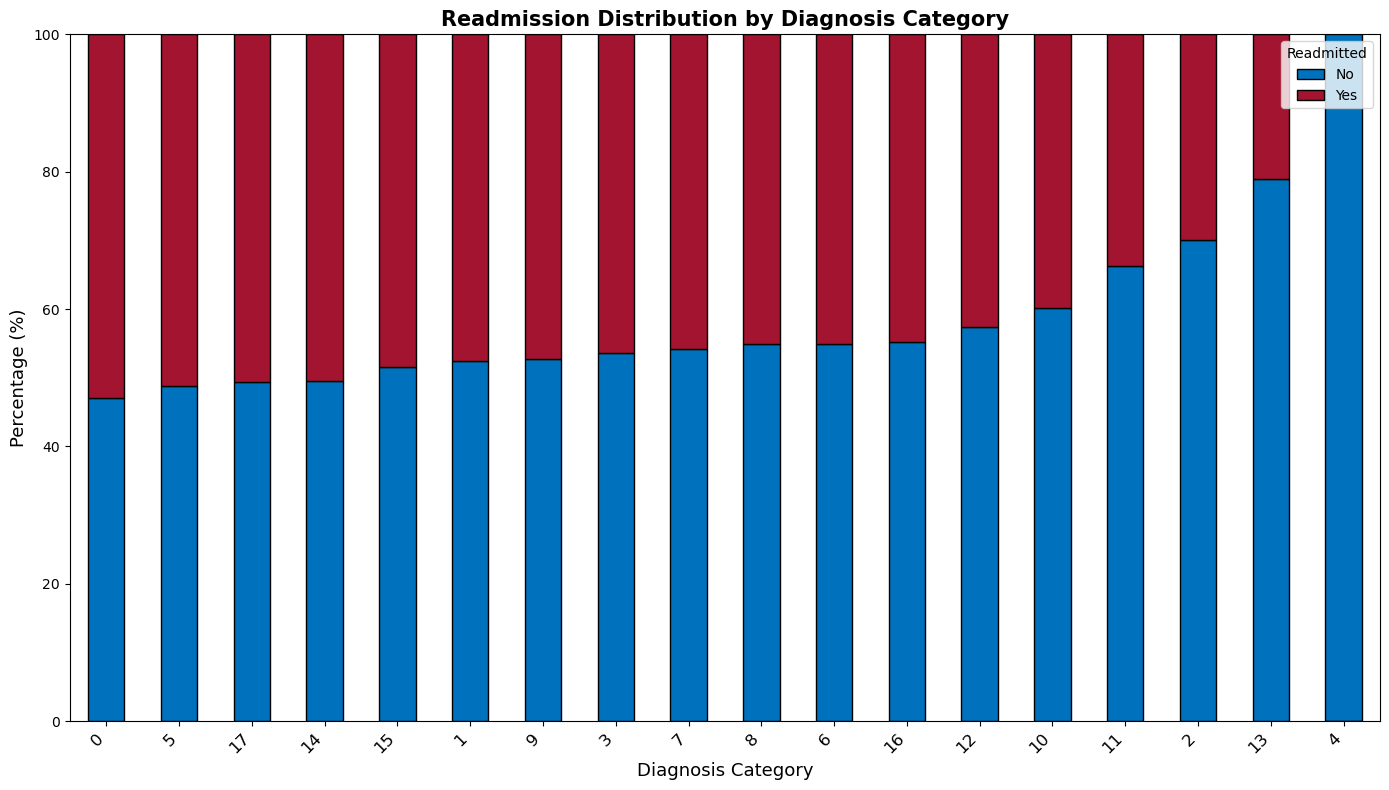

In [470]:
# Compute readmission percentage for each diagnosis category in diag_1_category
diag_category_counts = data.groupby(['diag_1_category', 'readmitted_binary']).size().unstack()

# Compute percentages
diag_category_percent = diag_category_counts.div(diag_category_counts.sum(axis=1), axis=0) * 100

# Compute the average readmission rate per diagnosis category
diag_category_readmit_rates = diag_category_percent[1].fillna(0).to_dict()

# Sort categories by highest readmission percentage
sorted_diag_categories = sorted(diag_category_readmit_rates, key=diag_category_readmit_rates.get, reverse=True)

# Create figure for subplots
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked bar chart for diagnosis categories
diag_category_percent.loc[sorted_diag_categories].plot(kind='bar', stacked=True, ax=ax, 
                                                       color=["#0072BD", "#A2142F"], edgecolor="black")

# Formatting
ax.set_title("Readmission Distribution by Diagnosis Category", fontsize=15, fontweight="bold")
ax.set_xlabel("Diagnosis Category", fontsize=13)
ax.set_ylabel("Percentage (%)", fontsize=13)
ax.set_ylim(0, 100)  # Ensure consistent scaling
ax.legend(title="Readmitted", labels=["No", "Yes"], loc='upper right')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


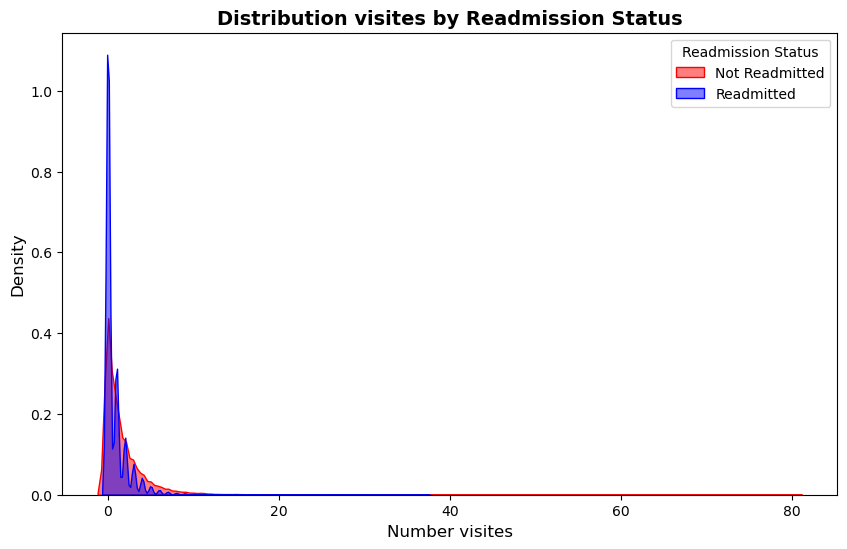

In [471]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=data, x="num_visits", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)  # Smooth bandwidth adjustment

# Labels & Title
plt.xlabel("Number visites", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution visites by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


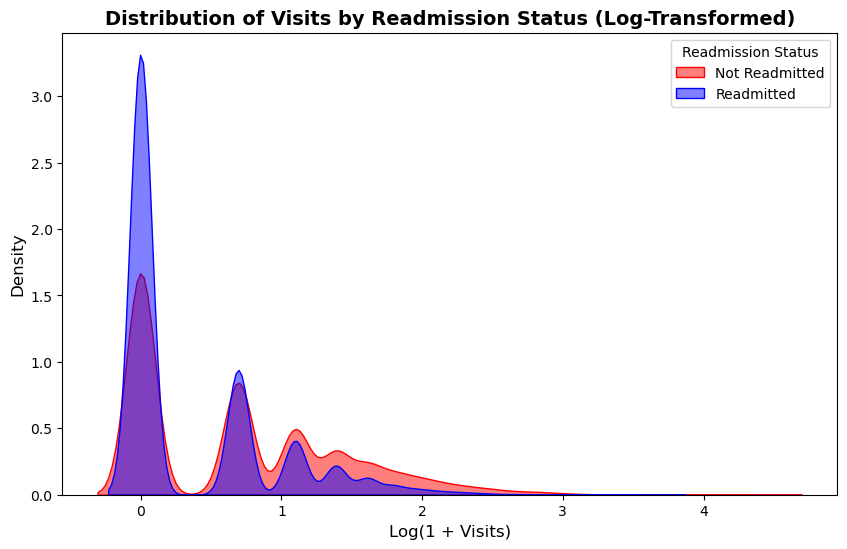

In [472]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted & Readmitted, applying log transformation on-the-fly
sns.kdeplot(data=data, 
            x=np.log1p(data['num_visits']), 
            hue=data['readmitted_binary'],
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)  # Smooth bandwidth adjustment

# Labels & Title
plt.xlabel("Log(1 + Visits)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Visits by Readmission Status (Log-Transformed)", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


In [473]:
from scipy.stats import mannwhitneyu

# Apply log transformation dynamically
readmitted_visits = np.log1p(data[data['readmitted_binary'] == 1]['num_visits'])
not_readmitted_visits = np.log1p(data[data['readmitted_binary'] == 0]['num_visits'])

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(readmitted_visits, not_readmitted_visits, alternative='greater')

# Print results
print("Mann-Whitney U Test Results:")
print(f"Statistic = {stat:.4f}, P-value = {p_value:.4e}")

if p_value < 0.05:
    print("P-value < 0.05: Reject Null Hypothesis (Significant Difference)")
else:
    print("P-value >= 0.05: Fail to Reject Null Hypothesis (No Significant Difference)")


Mann-Whitney U Test Results:
Statistic = 1496453014.5000, P-value = 0.0000e+00
P-value < 0.05: Reject Null Hypothesis (Significant Difference)


since p<0.05 it confirms that the number of visits is significantly different between readmitted and non-readmitted patients.

In [474]:
# checking other features if they need log transforming

# Ensure numerical_columns is a list
numerical_columns = list(numerical_columns)  # Convert to list if it's an Index

# Now append the new column
numerical_columns.append('num_visits')

# Initialize DataFrame to store statistics
statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = numerical_columns  # Using numerical_columns

# Lists to store statistics
skew_before = []
skew_after = []
kurt_before = []
kurt_after = []
standard_deviation_before = []
standard_deviation_after = []
log_transform_needed = []
log_type = []
p_values = []  # New column for statistical significance

# Iterate through numerical columns
for col in numerical_columns:
    skewval = data[col].skew()
    kurtval = data[col].kurtosis()
    sdval = data[col].std()
    
    skew_before.append(skewval)
    kurt_before.append(kurtval)
    standard_deviation_before.append(sdval)
    
    # Apply log transformation if skewness and kurtosis exceed the threshold
    if abs(skewval) > 2 and abs(kurtval) > 2:
        log_transform_needed.append('Yes')
        
        if (data[col] == 0).sum() / len(data) <= 0.02:
            log_type.append('log')
            transformed = np.log(data[col][data[col] > 0])  # Log transformation
        else:
            log_type.append('log1p')
            transformed = np.log1p(data[col])  # log1p for zero values

        # Store new stats after transformation
        skew_after.append(transformed.skew())
        kurt_after.append(transformed.kurtosis())
        standard_deviation_after.append(transformed.std())

        # Perform Mann-Whitney U test to check distribution shift
        stat, p_value = mannwhitneyu(data[col].dropna(), transformed.dropna(), alternative='two-sided')
        p_values.append(p_value)
        
    else:
        log_transform_needed.append('No')
        log_type.append('NA')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)
        p_values.append(np.nan)  # No transformation applied, so no test is needed

# Store results in DataFrame
statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after
statdataframe['p_value'] = p_values  # Add p-value column
statdataframe['p_value'] = statdataframe['p_value'].apply(lambda x: f"{x:.2e}" if not pd.isna(x) else "NaN")

# Display DataFrame
statdataframe


,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after,p_value
0,number_outpatient,8.781663,145.589922,1.283365e+00,Yes,log1p,2.714801,7.697978,4.328809e-01,1.76e-15
1,time_in_hospital|num_lab_procedures_ratio,8.482393,94.338036,7.327402e-01,Yes,log,1.324663,3.264529,1.000951e+00,0.00e+00
2,num_medications|number_diagnoses_mult,1.282764,3.142963,7.476948e+01,No,NA,1.282764,3.142963,7.476948e+01,NaN
3,num_medications|number_diagnoses_sum,1.062010,2.579494,8.733978e+00,No,NA,1.062010,2.579494,8.733978e+00,NaN
4,num_procedures,1.303967,0.823874,1.708475e+00,No,NA,1.303967,0.823874,1.708475e+00,NaN
5,number_diagnoses,-0.817531,-0.345022,1.832472e+00,No,NA,-0.817531,-0.345022,1.832472e+00,NaN
6,num_medications,1.332717,3.493545,8.108496e+00,No,NA,1.332717,3.493545,8.108496e+00,NaN
7,num_medications|num_lab_procedures_mult,1.831615,5.909041,5.896321e+02,No,NA,1.831615,5.909041,5.896321e+02,NaN
8,number_diagnoses|time_in_hospital_mult,1.270311,1.336267,2.633026e+01,No,NA,1.270311,1.336267,2.633026e+01,NaN
9,num_medications|num_procedures_ratio,0.976424,-0.045814,7.653433e+05,No,NA,0.976424,-0.045814,7.653433e+05,NaN


In [475]:
# Apply log transformation to necessary columns
log_transformed_data = data.copy() 

for index, row in statdataframe.iterrows():
    col = row['numeric_column']
    
    if row['log_transform_needed'] == 'Yes':
        if row['log_type'] == 'log':
            log_transformed_data[col] = np.log(log_transformed_data[col].replace(0, np.nan)) 
        elif row['log_type'] == 'log1p':
            log_transformed_data[col] = np.log1p(log_transformed_data[col])

In [476]:
# Sort data by patient ID and encounter date
data_sorted = log_transformed_data.sort_values(by=['patient_nbr', 'encounter_id'])

# Keep only the first encounter for each patient
collapsed_data = data_sorted.drop_duplicates(subset=['patient_nbr'], keep='first')

# Compute the total number of encounters for each patient
encounter_counts = log_transformed_data['patient_nbr'].value_counts().reset_index()
encounter_counts.columns = ['patient_nbr', 'total_encounters']

# Merge total encounters back to the collapsed dataset
collapsed_data = collapsed_data.merge(encounter_counts, on='patient_nbr', how='left')

# Display summary
print(f"Original dataset size: {len(log_transformed_data):,}")
print(f"Collapsed dataset size: {len(collapsed_data):,}")
print(f"Patients with multiple encounters (before collapsing): {(encounter_counts['total_encounters'] > 1).sum():,}")

# Display the updated dataset
collapsed_data


Original dataset size: 98,052
Collapsed dataset size: 68,629
Patients with multiple encounters (before collapsing): 16,280


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,num_medications|num_visits_mult,num_medications|num_visits_sum,num_medications|num_visits_ratio,num_medications_squared,time_in_hospital_squared,number_diagnoses_squared,num_medications_time_in_hospital_ratio,num_medications_num_lab_procedures_ratio,number_diagnoses_time_in_hospital_ratio,total_encounters
0,24437208,135,0,1,[50-60),2,0.000000,1,8,77,...,0.0,33,3300000.0,6.993015,4.158883,64,1.417065,-0.847298,0.999999,2
1,29758806,378,0,1,[50-60),3,0.000000,1,2,49,...,0.0,11,1100000.0,4.795791,1.386294,9,1.704743,-1.493925,1.499993,1
2,189899286,729,0,1,[80-90),1,1.098612,7,4,68,...,0.0,23,2300000.0,6.270988,2.772589,81,1.749197,-1.084014,2.249994,1
3,64331490,774,0,1,[80-90),1,0.000000,7,3,46,...,0.0,20,2000000.0,5.991465,2.197225,81,1.897117,-0.832909,2.999990,1
4,14824206,927,1,1,[30-40),1,0.000000,7,5,49,...,0.0,5,500000.0,3.218876,3.218876,9,-0.000002,-2.282383,0.599999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68624,418513058,189351095,0,1,[80-90),1,0.000000,7,1,73,...,0.0,11,1100000.0,4.795791,0.000000,81,2.397885,-1.892564,8.999910,1
68625,359719064,189365864,3,0,[60-70),1,0.000000,7,3,56,...,0.0,8,800000.0,4.158883,2.197225,49,0.980826,-1.945910,2.333326,1
68626,338462954,189445127,0,1,[80-90),1,0.000000,7,3,39,...,0.0,18,1800000.0,5.780744,2.197225,81,1.791756,-0.773190,2.999990,1
68627,443811536,189481478,0,1,[40-50),1,1.386294,7,14,69,...,0.0,16,1600000.0,5.545177,5.278115,25,0.133531,-1.461518,0.357143,1


### model

In [477]:
feature_set = [
    'race', 'gender',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses',
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed',
    'age_lable', 'diag_1_category', 'diag_2_category',
    'diag_3_category', 'num_visits', 'total_encounters',

    # Interaction Terms (Multiplication, Sum, and Ratio)
    'num_medications|time_in_hospital_mult', 'num_medications|time_in_hospital_sum', 'num_medications|time_in_hospital_ratio',
    'num_medications|num_procedures_mult', 'num_medications|num_procedures_sum', 'num_medications|num_procedures_ratio',
    'time_in_hospital|num_lab_procedures_mult', 'time_in_hospital|num_lab_procedures_sum', 'time_in_hospital|num_lab_procedures_ratio',
    'num_medications|num_lab_procedures_mult', 'num_medications|num_lab_procedures_sum', 'num_medications|num_lab_procedures_ratio',
    'num_medications|number_diagnoses_mult', 'num_medications|number_diagnoses_sum', 'num_medications|number_diagnoses_ratio',
    'change|num_medications_mult', 'change|num_medications_sum', 'change|num_medications_ratio',
    'number_diagnoses|time_in_hospital_mult', 'number_diagnoses|time_in_hospital_sum', 'number_diagnoses|time_in_hospital_ratio',
    'num_medications|num_visits_mult', 'num_medications|num_visits_sum', 'num_medications|num_visits_ratio',

    # Polynomial Features
    'num_medications_squared', 'time_in_hospital_squared', 'number_diagnoses_squared',

    # Healthcare Utilization Ratios
    'num_medications_time_in_hospital_ratio', 'num_medications_num_lab_procedures_ratio', 'number_diagnoses_time_in_hospital_ratio'
]


In [478]:
X = collapsed_data[feature_set]
y = collapsed_data['readmitted_binary']

In [479]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### First Decision Tree

In [480]:
# Train Decision Tree Classifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

# Make Predictions
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)


Accuracy is 0.78
Precision is 0.74
Recall is 0.70


In [481]:
# Expanded parameter grid
param_grid = {
    'max_depth': [10, 15, 20, 28, 35],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10], 
    'max_features': ['sqrt', 'log2', None]  
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy from Grid Search: {grid_search.best_score_:.4f}")

# Train the best model on full training data
best_dtree = grid_search.best_estimator_
best_dtree.fit(X_train, y_train)

# Make predictions
y_pred = best_dtree.predict(X_test)

# Evaluate performance
print("\nOptimized Model Performance:")
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Optimized Precision: {precision_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized Recall: {recall_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred, average='binary'):.4f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
Best Accuracy from Grid Search: 0.8261

Optimized Model Performance:
Optimized Accuracy: 0.8344
Optimized Precision: 0.9202
Optimized Recall: 0.6465
Optimized F1 Score: 0.7594

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      8176
           1       0.92      0.65      0.76      5550

    accuracy                           0.83     13726
   macro avg       0.86      0.80      0.82     13726
weighted avg       0.85      0.83      0.83     13726



### Selecting Features with high importance

In [482]:
importances = best_dtree.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(50))


                                      Feature  Importance
45                           total_encounters    0.788634
11                           number_inpatient    0.077196
3                    discharge_disposition_id    0.029259
2                           admission_type_id    0.012916
67            num_medications|num_visits_mult    0.011740
72                   number_diagnoses_squared    0.008668
6                          num_lab_procedures    0.007548
55    num_medications|num_lab_procedures_mult    0.004843
40                                  age_lable    0.004639
51       num_medications|num_procedures_ratio    0.003951
4                         admission_source_id    0.003951
13                              max_glu_serum    0.003530
74   num_medications_num_lab_procedures_ratio    0.002715
39                                diabetesMed    0.002686
52   time_in_hospital|num_lab_procedures_mult    0.002269
60     num_medications|number_diagnoses_ratio    0.002042
54  time_in_ho

In [483]:
# Define threshold for feature importance
threshold = 0.001  

# Filter out low-importance features
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

print(f"Number of selected features: {len(important_features)}")
print(f"Removed {len(feature_importance_df) - len(important_features)} features with importance < {threshold}.")


Number of selected features: 35
Removed 41 features with importance < 0.001.


In [484]:
# Keep only important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

### Training Random Forest Classifier

In [485]:
# Retrain the model with optimized feature set
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_filtered, y_train)

# Predictions
y_pred = model.predict(X_test_filtered)

# Evaluate Performance
print("Optimized Accuracy:", accuracy_score(y_test, y_pred))
print("Optimized Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Optimized Recall:", recall_score(y_test, y_pred, average='weighted'))
print("Optimized F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Optimized Accuracy: 0.8368060614891447
Optimized Precision: 0.8534819456594449
Optimized Recall: 0.8368060614891447
Optimized F1 Score: 0.8295848409141786


### Training XGBoost

In [486]:
xgb = XGBClassifier(n_estimators=200, max_depth=10, scale_pos_weight=2)  # Adjusts for imbalance
xgb.fit(X_train_filtered, y_train)

y_pred_xgb = xgb.predict(X_test_filtered)

print("XGBoost Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_xgb)))
print("XGBoost Precision: {:.2f}".format(precision_score(y_test, y_pred_xgb)))
print("XGBoost Recall: {:.2f}".format(recall_score(y_test, y_pred_xgb)))


XGBoost Accuracy: 0.81
XGBoost Precision: 0.81
XGBoost Recall: 0.71


### Training Logistic Regression

In [ ]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Define Logistic Regression Model with Increased Iterations
logit = LogisticRegression(
    penalty='l2', 
    solver='lbfgs', 
    max_iter=2000, 
    class_weight='balanced',
    random_state=42
)

# Train the Model
logit.fit(X_train_scaled, y_train)

# Predictions
y_pred_logit = logit.predict(X_test_scaled)

# Evaluate Performance
print("Logistic Regression Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_logit)))
print("Logistic Regression Precision: {:.2f}".format(precision_score(y_test, y_pred_logit, average='macro')))
print("Logistic Regression Recall: {:.2f}".format(recall_score(y_test, y_pred_logit, average='macro')))


Logistic Regression Accuracy: 0.84
Logistic Regression Precision: 0.85
Logistic Regression Recall: 0.81


### Neural Network

In [488]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)


In [489]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [490]:
# Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Small learning rate for stability
    loss='binary_crossentropy',  # Use binary cross-entropy for classification
    metrics=['accuracy', Precision(), Recall()]  # Track accuracy, precision, and recall
)

# Now fit the model
history = model.fit(
    X_train_scaled, y_train, 
    epochs=100,  # Train for more epochs
    batch_size=64,  # Smaller batch size for better generalization
    validation_data=(X_test_scaled, y_test),
    verbose=1
)



Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7298 - loss: 0.5506 - precision_7: 0.7031 - recall_7: 0.5891 - val_accuracy: 0.8360 - val_loss: 0.3924 - val_precision_7: 0.9292 - val_recall_7: 0.6434
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8207 - loss: 0.4164 - precision_7: 0.8900 - recall_7: 0.6404 - val_accuracy: 0.8368 - val_loss: 0.3810 - val_precision_7: 0.9270 - val_recall_7: 0.6474
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.8278 - loss: 0.3963 - precision_7: 0.9052 - recall_7: 0.6411 - val_accuracy: 0.8370 - val_loss: 0.3778 - val_precision_7: 0.9244 - val_recall_7: 0.6499
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.8289 - loss: 0.3973 - precision_7: 0.9136 - recall_7: 0.6425 - val_accuracy: 0.8399 - val_loss: 0.3780 - val_precision_7: 0.9146 - val_recall_7: 0.6661
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.8293 - loss: 0.3937 - precision_7: 0.9091 - recall_

In [491]:
# Evaluate performance
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print("Neural Network Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_nn)))
print("Neural Network Precision: {:.2f}".format(precision_score(y_test, y_pred_nn)))
print("Neural Network Recall: {:.2f}".format(recall_score(y_test, y_pred_nn)))
print("Neural Network F1 Score: {:.2f}".format(f1_score(y_test, y_pred_nn)))

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
Neural Network Accuracy: 0.84
Neural Network Precision: 0.89
Neural Network Recall: 0.68
Neural Network F1 Score: 0.77


In [492]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure y_train is a NumPy array
y_train_np = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_np), 
    y=y_train_np
)

# Convert class weights to dictionary
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 0.8394184019814696, 1: 1.236554054054054}


In [493]:
y_train_np = y_train_np.astype(int)


In [494]:
history = model.fit(
    X_train_scaled, y_train_np, 
    epochs=100, batch_size=64,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weights,  # Apply computed class weights
    verbose=1
)

Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8394 - loss: 0.3771 - precision_7: 0.8602 - recall_7: 0.7196 - val_accuracy: 0.8286 - val_loss: 0.3918 - val_precision_7: 0.8443 - val_recall_7: 0.7063
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8362 - loss: 0.3795 - precision_7: 0.8531 - recall_7: 0.7140 - val_accuracy: 0.8291 - val_loss: 0.3924 - val_precision_7: 0.8477 - val_recall_7: 0.7038
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8379 - loss: 0.3766 - precision_7: 0.8579 - recall_7: 0.7177 - val_accuracy: 0.8292 - val_loss: 0.3912 - val_precision_7: 0.8480 - val_recall_7: 0.7036
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8357 - loss: 0.3801 - precision_7: 0.8490 - recall_7: 0.7212 - val_accuracy: 0.8291 - val_loss: 0.3920 - val_precision_7: 0.8457 - val_recall_7: 0.7061
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8378 - loss: 0.3804 - precision_7: 0.8563 - recall_7: 0.7

In [495]:
# Evaluate performance
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print("Neural Network Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_nn)))
print("Neural Network Precision: {:.2f}".format(precision_score(y_test, y_pred_nn)))
print("Neural Network Recall: {:.2f}".format(recall_score(y_test, y_pred_nn)))
print("Neural Network F1 Score: {:.2f}".format(f1_score(y_test, y_pred_nn)))

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
Neural Network Accuracy: 0.83
Neural Network Precision: 0.84
Neural Network Recall: 0.71
Neural Network F1 Score: 0.77


### Compare models

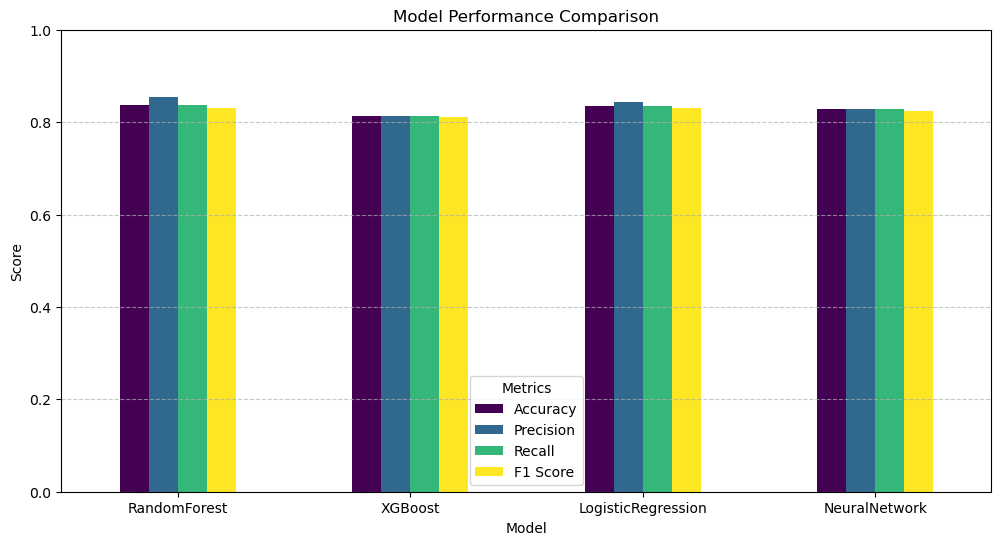

In [496]:
# Replace these variables with actual predictions from your models
models = ["RandomForest", "XGBoost", "LogisticRegression", "NeuralNetwork"]

accuracy = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_logit),
    accuracy_score(y_test, y_pred_nn)
]

precision = [
    precision_score(y_test, y_pred, average='weighted'),
    precision_score(y_test, y_pred_xgb, average='weighted'),
    precision_score(y_test, y_pred_logit, average='weighted'),
    precision_score(y_test, y_pred_nn, average='weighted')
]

recall = [
    recall_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred_xgb, average='weighted'),
    recall_score(y_test, y_pred_logit, average='weighted'),
    recall_score(y_test, y_pred_nn, average='weighted')
]

f1_score_values = [
    f1_score(y_test, y_pred, average='weighted'),
    f1_score(y_test, y_pred_xgb, average='weighted'),
    f1_score(y_test, y_pred_logit, average='weighted'),
    f1_score(y_test, y_pred_nn, average='weighted')
]

# Convert metrics to DataFrame
df_metrics = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score_values
})

# 📊 Plot Performance Metrics
fig, ax = plt.subplots(figsize=(12, 6))
df_metrics.set_index("Model").plot(kind="bar", ax=ax, rot=0, colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()
